In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.weightstats as wst
import pandas_ml as pdml
import xgboost as xgb
import lightgbm as lgb 

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import IsolationForest

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [165]:
#Read the prepared dataset
loans = pd.read_csv('prepared_loans.csv')
#create ModelFrame object
loans_mf = pdml.ModelFrame(loans)
#loans_mf.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [166]:
#Split into training and test data sets
train_loans, test_loans = loans_mf.model_selection.train_test_split(test_size = 0.30, random_state = 5)

In [205]:
train_loans.target.value_counts()

0    166609
1     25310
Name: .target, dtype: int64

In [214]:
#Oversampling the training dataset
sampler = train_loans.imbalance.over_sampling.SMOTE()
sampled_lr_loans = train_loans.fit_sample(sampler)

In [215]:
sampled_lr_loans.target.value_counts()

1    166609
0    166609
Name: .target, dtype: int64

## Light GBM

In [216]:
train_lgb = lgb.Dataset(sampled_lr_loans.data, label=sampled_lr_loans.target)

param = {'num_leaves':1000, 'objective':'binary','max_depth':17,'learning_rate':0.15,'max_bin':200}
param['metric'] = ['auc', 'f1_weighted']
param['min_data_in_leaf'] = 150

In [217]:
num_round=500
lgbm=lgb.train(param,train_lgb,num_round)


In [218]:
predict_prob=lgbm.predict(test_loans.data)
predicted = np.array([0 if p < 0.4 else 1 for p in predict_prob])

In [219]:
pd.Series(predicted).value_counts()

0    76053
1     6199
dtype: int64

In [220]:
print ("AUC Score (Test): %f" % roc_auc_score(np.array(test_loans.target), np.array(predicted)))
   
print ("Class Level precision recall (Test):")
prec, recall, f1, support = precision_recall_fscore_support(np.array(test_loans.target), np.array(predicted))

prf_test = pd.DataFrame({'Precision': prec, 'Recall': recall, 'F1': f1, 'Total': support})    
print (prf_test)

AUC Score (Test): 0.670561
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.939492   0.911759  0.968964  71563
1  0.471104   0.641716  0.372158  10689


                            Importance                     feature
total_il_high_credit_limit        8593  total_il_high_credit_limit
dti                               7243                         dti
bc_open_to_buy                    6764              bc_open_to_buy
mo_sin_old_il_acct                6594          mo_sin_old_il_acct
annual_inc                        6337                  annual_inc


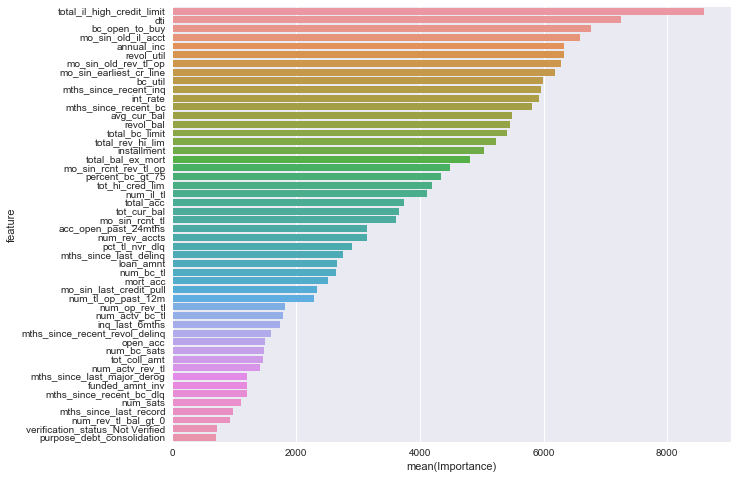

In [180]:
importance = lgbm.feature_importance()
importance = pd.DataFrame(importance, index=train_loans.data.columns, 
                          columns=["Importance"])
importance.sort_values('Importance', ascending = False, inplace=True)
importance['feature'] = importance.index
print(importance.head())
sns.barplot(y = 'feature', x = 'Importance', data= importance.head(50) )

In [173]:
def modelfit(alg, train_mf, test_mf, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_mf.data, label=train_mf.target, feature_names=list(train_loans.data.columns))
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_mf.data, train_mf.target,eval_metric='map')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train_mf.data)
    dtrain_predprob = alg.predict_proba(train_mf.data)[:,1]
    
    #Predict test st
    dtest_predictions = alg.predict(test_mf.data)
    dtest_predprob = alg.predict_proba(test_mf.data)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("F1 Score (Train) : %.4g" % f1_score(np.array(train_mf.target), dtrain_predictions))
    print ("F1 Score (Test) : %.4g" % f1_score(np.array(test_mf.target), dtest_predictions))
    
    print ("AUC Score (Train): %f" % roc_auc_score(np.array(train_mf.target), dtrain_predprob))
    print ("AUC Score (Test): %f" % roc_auc_score(np.array(test_mf.target), dtest_predprob))
   
    print ("Class Level precision recall (Test):")
    prec, recall, f1, support = precision_recall_fscore_support(np.array(test_mf.target), dtest_predictions)

    prf_test = pd.DataFrame({'Precision': prec, 'Recall': recall, 'F1': f1, 'Total': support})
    print (prf_test)
    #plot_importance(alg)
    importance = alg.feature_importances_
    importance = pd.DataFrame(importance, index=train_mf.data.columns, 
                          columns=["Importance"])
    importance.sort_values('Importance', ascending = False, inplace=True)
    importance['feature'] = importance.index
    print(importance.head())
    sns.barplot(y = 'feature', x = 'Importance', data= importance.head(50) )

In [174]:
def modelscore(alg, test_mf, param_text ) :
    print("-----------------------------------------------------------------------------------------------------------")
    print(param_text)
    print ("AUC Score (Test): %f" % roc_auc_score(np.array(test_mf.target), np.array(test_mf.predict(alg))))
   
    print ("Class Level precision recall (Test):")
    prec, recall, f1, support = precision_recall_fscore_support(np.array(test_mf.target), np.array(test_mf.predict(alg)))

    prf_test = pd.DataFrame({'Precision': prec, 'Recall': recall, 'F1': f1, 'Total': support})
    print (prf_test)

### XGBoost with pandas_ml

In [175]:
#Using XGBoost without CV
xg_est = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=6, max_depth=17, gamma=0.1, max_delta_step=1,
                                        subsample=0.4, colsample_bytree = 0.5, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=500  )


Model Report
F1 Score (Train) : 0.9994
F1 Score (Test) : 0.4248
AUC Score (Train): 1.000000
AUC Score (Test): 0.798675
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.936466   0.905807  0.969272  71563
1  0.424835   0.612511  0.325194  10689
                Importance         feature
dti               0.039208             dti
revol_util        0.037926      revol_util
annual_inc        0.035107      annual_inc
revol_bal         0.034981       revol_bal
bc_open_to_buy    0.034723  bc_open_to_buy


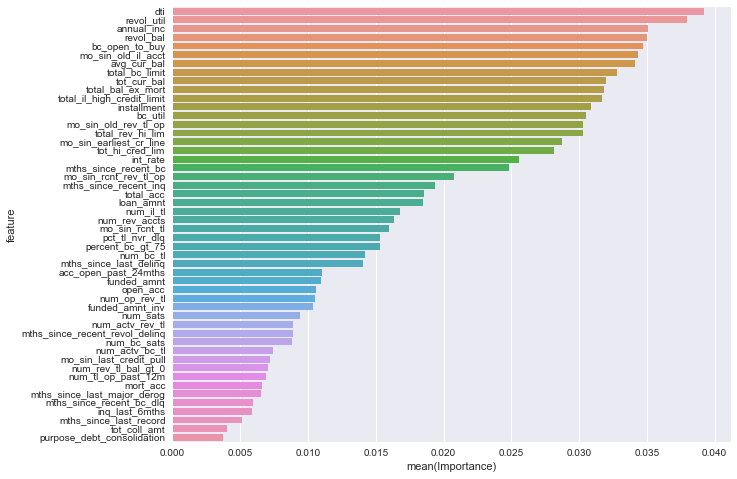

In [176]:
modelfit(xg_est, train_loans, test_loans, useTrainCV= False )

In [20]:
#Test 1 - max_depth and min_child_weight
param1_vals = range(18,21,1)
param2_vals = range(6, 7, 1)
#param_1 = param_test1.ke
for param1_val in param1_vals  :
    xg_est.set_params(max_depth = param1_val)
    for param2_val in param2_vals :
        xg_est.set_params(min_child_weight = param2_val)
        train_loans.fit(xg_est )
        modelscore(xg_est, test_loans, 'max_depth= '+str(param1_val)+ ' min_child_weight= '+str(param2_val))
    


-----------------------------------------------------------------------------------------------------------
max_depth= 18 min_child_weight= 6
AUC Score (Test): 0.507315
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.040198   0.348066  0.021331  11814
1  0.920811   0.858184  0.993299  70438
-----------------------------------------------------------------------------------------------------------
max_depth= 19 min_child_weight= 6
AUC Score (Test): 0.507087
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.040232   0.331586  0.021415  11814
1  0.920547   0.858128  0.992760  70438
-----------------------------------------------------------------------------------------------------------
max_depth= 20 min_child_weight= 6
AUC Score (Test): 0.507757
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.042719   0.344872  0.022770  11814
1  0.920637   0.858295  0.992745  70438


In [22]:
#Test 2 - gamma
param1_vals = [0, 0.1, 0.2, 0.3]
for param1_val in param1_vals  :
    xg_est.set_params(gamma = param1_val)
    train_loans.fit(xg_est )
    modelscore(xg_est, test_loans, 'gamma= '+str(param1_val))

-----------------------------------------------------------------------------------------------------------
gamma= 0
AUC Score (Test): 0.506342
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.036457   0.328530  0.019299  11814
1  0.920708   0.857942  0.993384  70438
-----------------------------------------------------------------------------------------------------------
gamma= 0.1
AUC Score (Test): 0.507280
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.039770   0.351695  0.021077  11814
1  0.920885   0.858175  0.993484  70438
-----------------------------------------------------------------------------------------------------------
gamma= 0.2
AUC Score (Test): 0.506554
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.036684   0.341282  0.019384  11814
1  0.920885   0.857994  0.993725  70438
---------------------------------------------------------------------------------------------

In [33]:
#Test 3 - subsample and colsample_bytree

param1_vals = [i/10.0 for i in range(4,7)]
param2_vals = [i/10.0 for i in range(4,7)]

for param1_val in param1_vals  :
    xg_est.set_params(subsample = param1_val)
    for param2_val in param2_vals :
        xg_est.set_params(colsample_bytree = param2_val)
        train_loans.fit(xg_est )
        modelscore(xg_est, test_loans, 'subsample= '+str(param1_val)+ ' colsample_bytree= '+str(param2_val))

-----------------------------------------------------------------------------------------------------------
subsample= 0.4 colsample_bytree= 0.4
AUC Score (Test): 0.507882
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.047816   0.298929  0.025986  11814
1  0.919380   0.858332  0.989778  70438
-----------------------------------------------------------------------------------------------------------
subsample= 0.4 colsample_bytree= 0.5
AUC Score (Test): 0.510209
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.056390   0.332117  0.030811  11814
1  0.919641   0.858914  0.989608  70438
-----------------------------------------------------------------------------------------------------------
subsample= 0.4 colsample_bytree= 0.6
AUC Score (Test): 0.509516
Class Level precision recall (Test):
         F1  Precision    Recall  Total
0  0.055097   0.311790  0.030218  11814
1  0.919199   0.858742  0.988813  70438
-------------

## XG Boost

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_loans.data, label = train_loans.target, feature_names=list(train_loans.data.columns))
#clf_xg = xgb.xgboost()
dtest = xgb.DMatrix(test_loans.data, label = test_loans.target, feature_names=list(train_loans.data.columns))

In [ ]:
param = {'base_score' : 0.5,'objective':'binary:logistic', 'learning_rate':0.1, 'colsample_bylevel' : 1, 
        'colsample_bytree': 1, }
param['gamma'] = 0
param['max_depth'] = 15
param['scale_pos_weight']= 0.17
param['min_child_weight']=1
param['max_delta_step'] = 1
param['eval_metric'] = 'error'

evallist  = [(dtest,'eval'), (dtrain,'train')]

num_round = 50
bst = xgb.train( param, dtrain, num_round )


In [ ]:
predicted = bst.predict(dtest )
predicted_new = np.array([1 if p >= 0.5 else 0 for p in predicted])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, f1, support = precision_recall_fscore_support(np.array(test_loans.target), predicted_new)

prf_test = pd.DataFrame({'Precision': prec, 'Recall': recall, 'F1': f1, 'Total': support})
print (prf_test)

## Random Forest

In [ ]:
#RF using CV
rf_est = loans_mf.ensemble.RandomForestClassifier()
parameters = {'n_estimators' : [10, 20, 30],
              'criterion': ['gini', 'entropy'],
              'min_samples_split' : [10, 15, 20],
              'min_samples_leaf': [5, 10],
             'max_features': ['auto']}
rf_cv = loans_mf.model_selection.GridSearchCV(rf_est, parameters )

In [92]:
#RF without CV
rf_est = loans_mf.ensemble.RandomForestClassifier(n_estimators = 100, max_features = 40, criterion = 'gini', class_weight = 'balanced')

In [93]:
#sample_weight = np.array([6 if i == 1 else 1 for i in train_loans.target])
train_loans.fit(rf_est)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=40,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
predicted = test_loans.predict(rf_est)

In [95]:
test_loans.metrics.precision_recall_fscore_support()

,precision,recall,f1-score,support
0,0.901634,0.979081,0.938763,71563
1,0.670410,0.284872,0.399842,10689


                         Importance                  feature
mo_sin_last_credit_pull    0.228334  mo_sin_last_credit_pull
int_rate                   0.049636                 int_rate
dti                        0.026762                      dti
annual_inc                 0.026410               annual_inc
mo_sin_old_rev_tl_op       0.021381     mo_sin_old_rev_tl_op


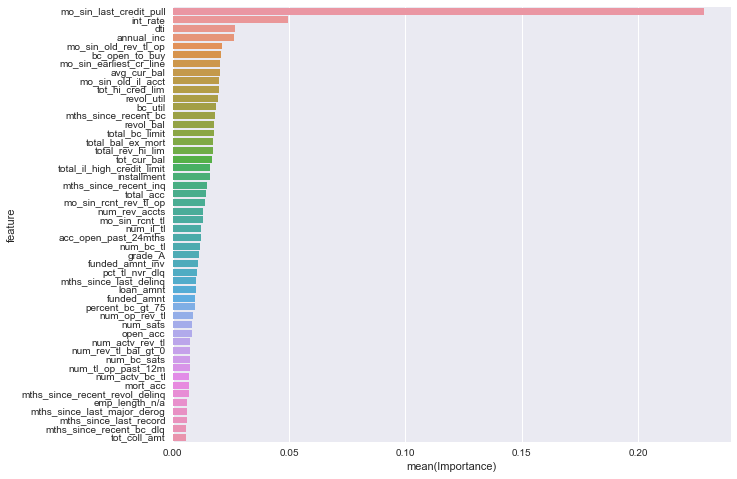

In [222]:
importance = rf_est.feature_importances_
importance = pd.DataFrame(importance, index=train_loans.data.columns, 
                          columns=["Importance"])
importance.sort_values('Importance', ascending = False, inplace=True)

importance['feature'] = importance.index
print(importance.head())
sns.barplot(y = 'feature', x = 'Importance', data= importance.head(50) )
x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

#plt.bar(x, y, yerr=yerr, align="center")

#plt.show()